# Project 2
Group members: Lena Jörg, Sigurd Kolltveit, Gregor Moe

In [1]:
#import numpy as np
import autograd.numpy as np  # required for automatic differentiation
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Model system 3.1 - 2D charged particle

In [2]:
def B_particle(x):
    x1 = x[0]
    x2 = x[1]
    return np.array([0,0,np.sqrt(x1**2+x2**2)])

def A_particle(x):
    x1 = x[0]
    x2 = x[1]
    return np.array([-x2*np.sqrt(x1**2+x2**2), x1*np.sqrt(x1**2+x2**2), 0])/3

def U_particle(x):
    x1 = x[0]
    x2 = x[1]
    return 1/(100*np.sqrt(x1**2 + x2**2))

def gradU_particle(x):
    x1 = x[0]
    x2 = x[1]
    u0 = x1/((x1**2 + x2**2)**(3/2))
    u1 = x2/((x1**2 + x2**2)**(3/2))
    return np.array([u0,u1,0])/(-100)

x0_particle = np.array([0.0, 1.0, 0.1], dtype=float)
v0_particle = np.array([0.09, 0.05, 0.20], dtype=float) 

Model system 3.2 - Tokamak magnetic field

In [3]:
def B_tokamak(x):
    x1,x2,x3 = x
    b1 = -(2*x1 + x1*x3)/(2*(x1**2+x2**2))
    b2 = (2*x1 - x2*x3)/(2*(x1**2+x2**2))
    b3 = (np.sqrt(x1**2 + x2**2) - 1)/(2*np.sqrt(x1**2+x2**2))
    return np.array([b1, b2, b3])

def A_tokamak(x):
    x1,x2,x3 = x
    a2 = (x1 - np.log(np.sqrt(x1**2 + x2**2) + x1))/2
    a3 = (x3*np.arctan2(x2, x1) + np.log(x1**2 + x2**2))/(-2)
    return np.array([0, a2, a3])

def U_tokamak(x):
    return 0

def gradU_tokamak(x):
    return np.array([0, 0, 0])

x0_tokamak = np.array([1.2, 0, 0], dtype=float)
v0_tokamak = np.array([0, 4.816e-4, -2.059e-3], dtype=float)

### Boris method implementation

In [4]:
def boris_step(x, v_half, h, B, gradU):
    v_minus = v_half - 0.5 * h * gradU(x)

    t = 0.5 * h * B(x)
    t_mag2 = np.dot(t, t)

    v_prime = v_minus + np.cross(v_minus, t)
    s = 2 * t / (1 + t_mag2)

    v_plus = v_minus + np.cross(v_prime, s)
    v_half_next = v_plus - 0.5 * h * gradU(x)

    x_next = x + h * v_half_next
    return x_next, v_half_next


def initialize_v_half(x0, v0, h, B, gradU):
    def rhs(t, y):
        x, v = y[:3], y[3:]
        return np.concatenate([v, np.cross(v, B(x)) - gradU(x)])
    
    sol = solve_ivp(rhs, [0, -h/2], np.concatenate([x0, v0]), rtol=1e-10, atol=1e-12)
    return sol.y[3:, -1]


def boris_integrate(x0, v0, T, h, B, gradU):
    N = int(T/h)
    x = np.zeros((N, 3))
    v_half = np.zeros((N, 3))

    x[0] = x0
    v_half[0] = initialize_v_half(x0, v0, h, B, gradU)

    for n in range(N-1):
        x[n+1], v_half[n+1] = boris_step(x[n], v_half[n], h, B, gradU)

    return x, v_half

# Convert half-step velocities to integer-step velocities
def v_integer(v_half):
    return 0.5 * (v_half[:-1] + v_half[1:])

### Runge-Kutta 4 implementation

In [5]:
def rk4_step(x_prev,v_prev,h,f):
    kx1 = h*v_prev
    kv1 = h*f(x_prev,v_prev)

    kx2 = h*(v_prev + kv1/2)
    kv2 = h*f(x_prev + kx1/2, v_prev + kv1/2)

    kx3 = h*(v_prev + kv2/2)
    kv3 = h*f(x_prev + kx2/2, v_prev + kv2/2)

    kx4 = h*(v_prev + kv3)
    kv4 = h*f(x_prev + kx3, v_prev + kv3)

    v = v_prev + (kv1 + 2*kv2 + 2*kv3 + kv4)/6
    x = x_prev + (kx1 + 2*kx2 + 2*kx3 + kx4)/6
    return x, v

def rk4(Tmax,h, x0, v0, B_func, A_func, U_func, gradU_func):
    maxiter = int(Tmax/h)

    xs = np.zeros((maxiter,3))
    vs = np.zeros((maxiter,3))
    xs[0] = x0
    vs[0] = v0
    f = lambda x,v: np.cross(v,B_func(x)) - gradU_func(x)
    
    i = 1 
    while i<maxiter: #regner denne iterasjonen
        xs[i], vs[i] = rk4_step(xs[i-1],vs[i-1],h,f)
        i += 1
    return xs, vs

### Fourth-order symmetric multistep method implementation

In [6]:
from scipy.integrate import solve_ivp


# uses solve_ivp to get the initial n points of the solution
def initial_soln(x0, v0, B, gradU, h, Tmax):
    n = int(Tmax / h)
    def rhs(t, y):
        x, v = y[:3], y[3:]
        return np.concatenate([v, np.cross(v, B(x)) - gradU(x)])

    ts = [k * h for k in range(n)] # we only want the soln at these points
    res = solve_ivp(rhs, (0, h*n), [*x0, *v0], t_eval=ts, rtol=1e-10, atol=1e-12)
    x = res.y[:3].transpose()
    v = res.y[3:].transpose()
    return x, v



In [7]:
from autograd import jacobian


A_particle_jacobian = jacobian(A_particle)
A_tokamak_jacobian = jacobian(A_tokamak)


# calculates the five-point central difference of the array y at j
def Δ(y, j, f=lambda x: x):
    return (1/12) * (f(y[j-2]) - 8*f(y[j-1]) + 8*f(y[j+1]) - f(y[j+2]))


def fourth_order_multistep(x0, v0, B, A, A_diff, gradU, h, Tmax):
    n = int(Tmax / h)
    def F(j, x, v):
        v[j] = Δ(x, j)/h
        A_delta_j = Δ(x, j, A)/h

        return A_diff(x[j]).mT @ v[j] - A_delta_j - gradU(x[j])


    a1, a2, a3 = -0.7, 0.1, 0.9
    beta0 = (1/3) * (20*a1*a2*a3 - 4*(a1*a2 + a1*a3 + a2*a3) - 28*(a1 + a2 + a3) - 52)
    beta1 = (1/3) * (2*a1*a2*a3 + 14*(a1*a2 + a1*a3 + a2*a3) + 26*(a1 + a2 + a3) + 38)
    alpha = (1, -7/5, 9/25, 22/125, -34/125, 22/125, 9/25, -7/5, 1)

    x, v = initial_soln(x0, v0, B, gradU, h, 8 * h) # get initial 8 points

    # pad with zeroes on the right
    x = np.pad(x, ((0, n-8), (0, 0)))
    v = np.pad(v, ((0, n-8), (0, 0)))
    assert v.shape == x.shape == (n, 3)

    for k in range(4, n-4):
        other_xs = np.dot(alpha[:-1], x[k-4:k+4])  # j = 4 is omitted from this sum
        Fnmin1 = F(k-1, x, v)
        Fn = F(k, x, v)
        Fnplus1 = F(k+1, x, v)
        x[k+4] = h**2 * (beta1 * Fnmin1 + beta0*Fn + beta1*Fnplus1) - other_xs

    v[n-3:] = v[n-4]
    
    return x, v



## Trajectory plots

In [8]:
Tmax = 1000
h = 0.1


def plot_trajectory(x, system, method):
    plt.figure(figsize=(6,6))
    plt.plot(x[:,0], x[:,1])
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.title(f"Trajectory in (x₁, x₂) for {system} ({method})")
    plt.axis("equal")
    plt.grid(True)
    plt.show()


def tokamak_banana_orbit(x, method):
    R = np.sqrt(x[:,0]**2 + x[:,1]**2)
    plt.figure(figsize=(6,6))
    plt.plot(R, x[:,2])
    plt.xlabel("R = sqrt(x₁² + x₂²)")
    plt.ylabel("x₃")
    plt.title(f"Banana Orbit (Tokamak Field, {method})")
    plt.grid(True)
    plt.show()

#### Boris method

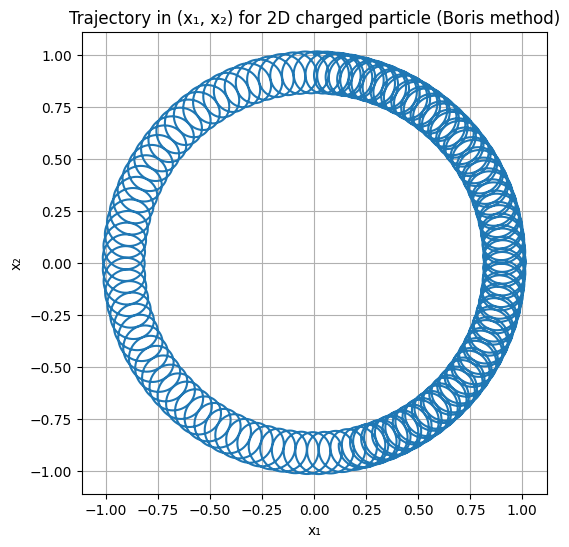

In [9]:
boris_x_2D, v_half_2D = boris_integrate(x0_particle, v0_particle, Tmax, h, B_particle, gradU_particle)
boris_v_2D = np.pad(v_integer(v_half_2D), ((0, 1), (0, 0)), mode="edge")

plot_trajectory(boris_x_2D, "2D charged particle", "Boris method")

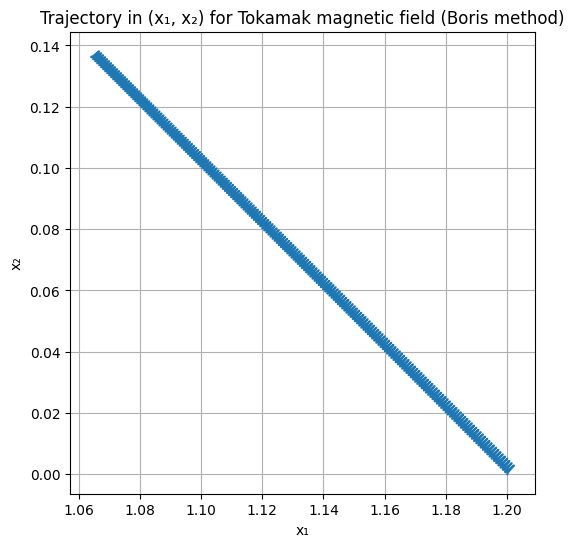

In [10]:
boris_x_tok, v_half_tok = boris_integrate(x0_tokamak, v0_tokamak, Tmax, h, B_tokamak, gradU_tokamak)
boris_v_tok = np.pad(v_integer(v_half_tok), ((0, 1), (0, 0)), mode="edge")

plot_trajectory(boris_x_tok, "Tokamak magnetic field", "Boris method")

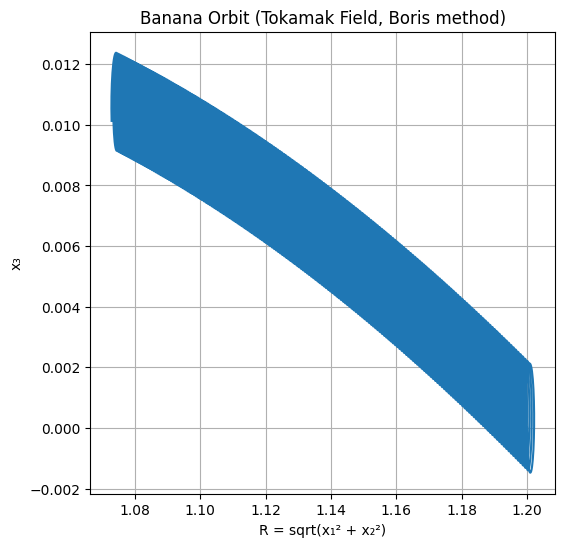

In [11]:
tokamak_banana_orbit(boris_x_tok, "Boris method")

#### Runge-Kutta 4

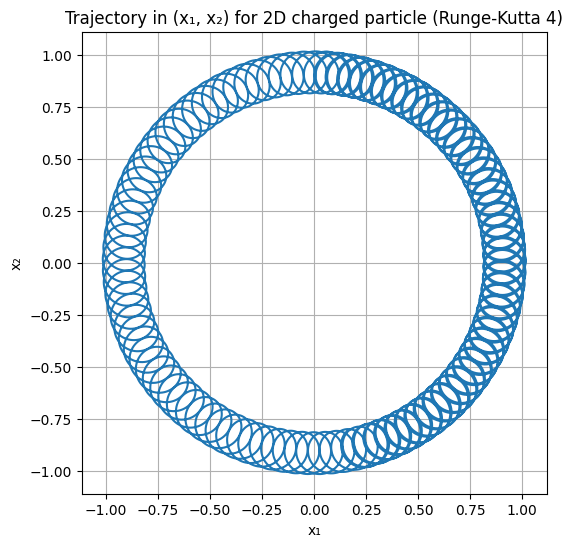

In [12]:

rk4_x_2D, rk4_v_2D = rk4(Tmax, h, x0_particle, v0_particle, B_particle, A_particle, U_particle, gradU_particle)

plot_trajectory(rk4_x_2D, "2D charged particle", "Runge-Kutta 4")

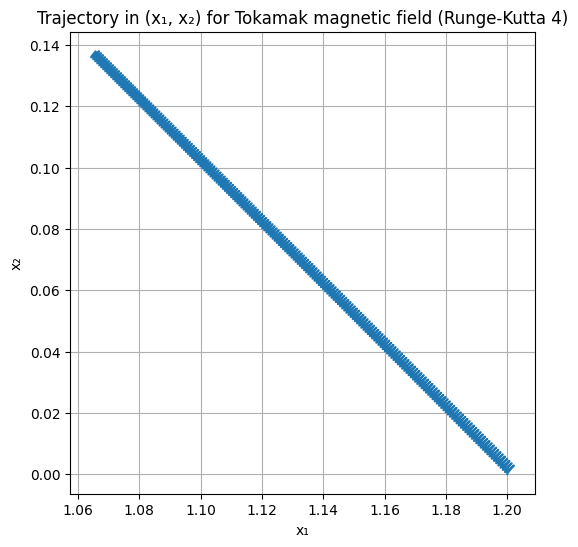

In [13]:
rk4_x_tok, rk4_v_tok = rk4(Tmax, h, x0_tokamak, v0_tokamak, B_tokamak, A_tokamak, U_tokamak, gradU_tokamak)

plot_trajectory(rk4_x_tok, "Tokamak magnetic field", "Runge-Kutta 4")

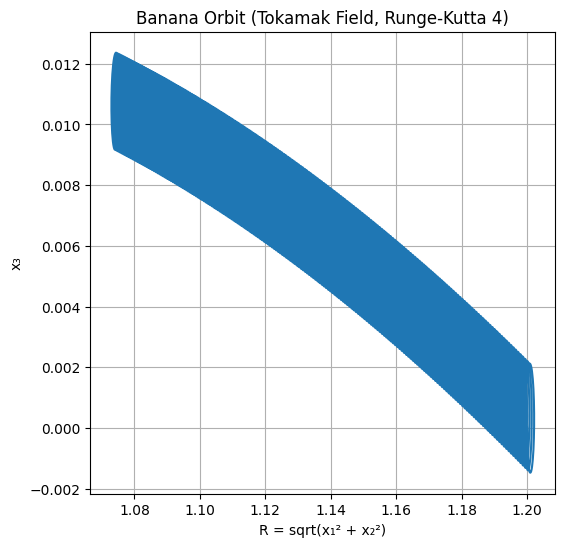

In [14]:
tokamak_banana_orbit(rk4_x_tok, "Runge-Kutta 4")

#### Fourth-order symmetric multistep method

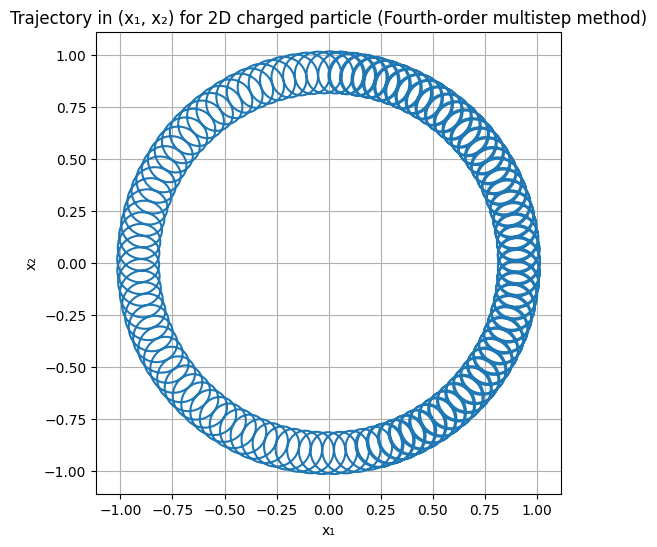

In [15]:
multistep_x_2D, multistep_v_2D = fourth_order_multistep(x0_particle, v0_particle, B_particle, A_particle, A_particle_jacobian, gradU_particle, h, Tmax)

plot_trajectory(multistep_x_2D, "2D charged particle", "Fourth-order multistep method")

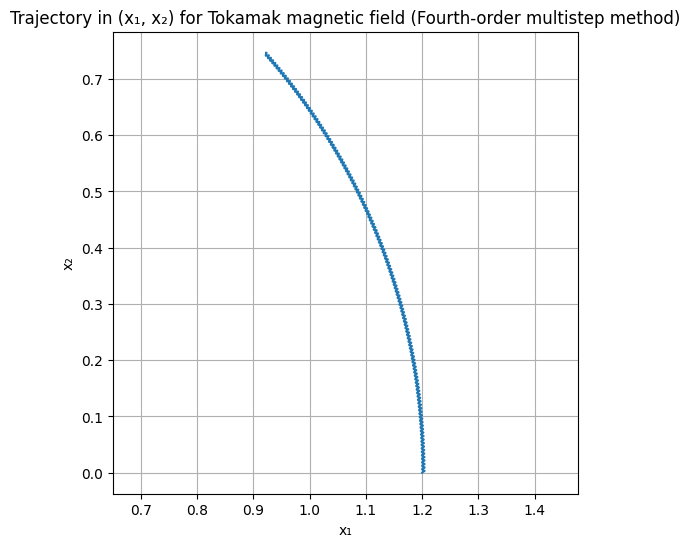

In [16]:
multistep_x_tok, multistep_v_tok = fourth_order_multistep(x0_tokamak, v0_tokamak, B_tokamak, A_tokamak, A_tokamak_jacobian, gradU_tokamak, h, Tmax)

plot_trajectory(multistep_x_tok, "Tokamak magnetic field", "Fourth-order multistep method")

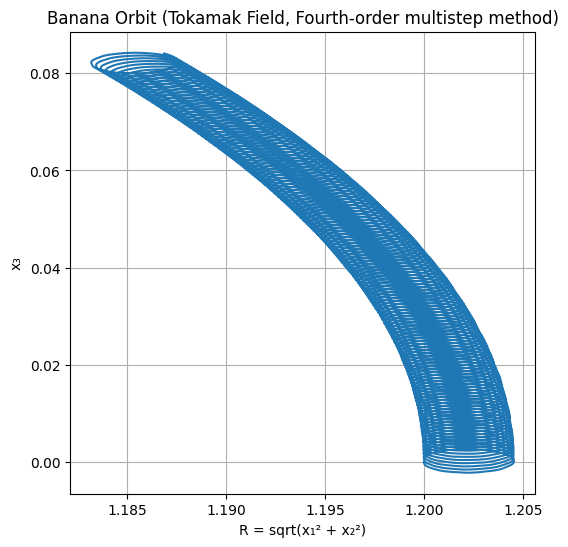

In [17]:
tokamak_banana_orbit(multistep_x_tok, "Fourth-order multistep method")

Note that for the fourth-order multistep method, the tokamak magnetic field trajectory differs slightly from the other two methods, and also from the reference solution, as shown in the error plots below. This might be because as mentioned in Hairer and Lubich, implementation must be done carefully to avoid round-off errors, however here we have just done a straightforward implementation of the formulas.

## Error plots

In [18]:
particle_reference_soln, _ = initial_soln(x0_particle, v0_particle, B_particle, gradU_particle, h, Tmax)
tokamak_reference_soln, _ = initial_soln(x0_tokamak, v0_tokamak, B_tokamak, gradU_tokamak, h, Tmax)


def plot_error(x, reference, title):
    assert x.shape == reference.shape
    N = int(Tmax / h)
    t = np.linspace(0, Tmax, N)
    error = np.linalg.norm(x - reference, axis=1)
    assert error.shape == (N,)
    plt.semilogy(t, error)
    plt.title(title)
    plt.xlabel("t")
    plt.ylabel("error")
    plt.show()

#### Boris method

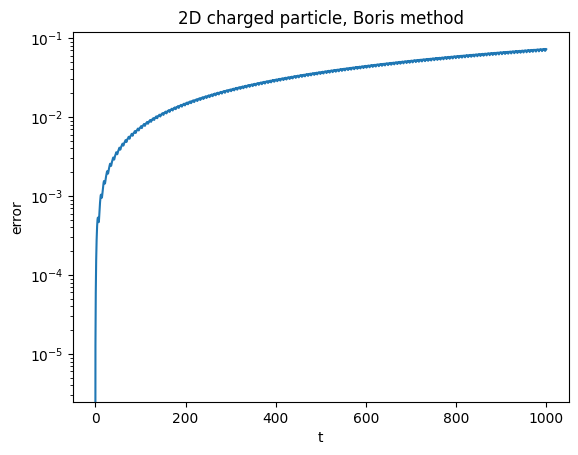

In [19]:
plot_error(boris_x_2D, particle_reference_soln, "2D charged particle, Boris method")

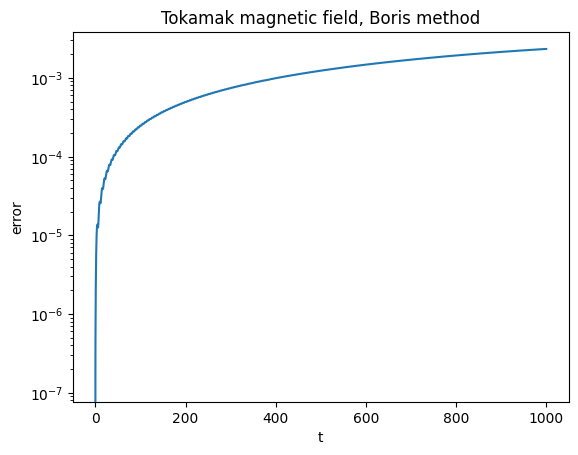

In [20]:
plot_error(boris_x_tok, tokamak_reference_soln, "Tokamak magnetic field, Boris method")

#### Runge-Kutta 4

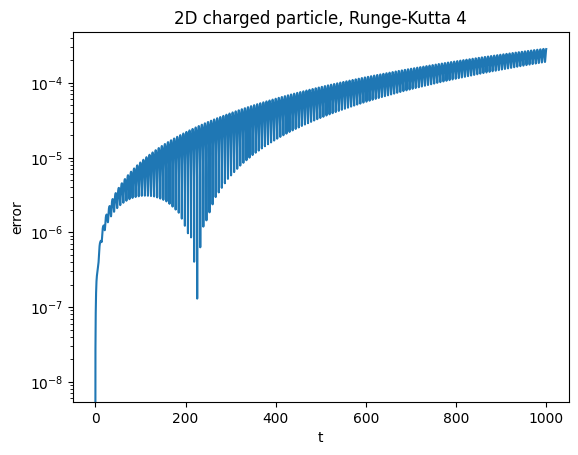

In [21]:
plot_error(rk4_x_2D, particle_reference_soln, "2D charged particle, Runge-Kutta 4")

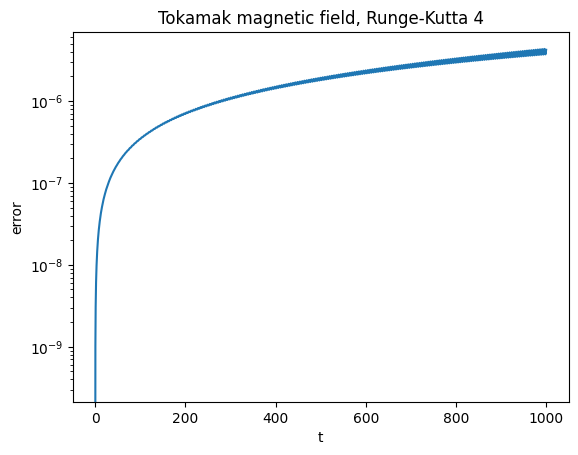

In [22]:
plot_error(rk4_x_tok, tokamak_reference_soln, "Tokamak magnetic field, Runge-Kutta 4")

#### Fourth-order symmetric multistep method

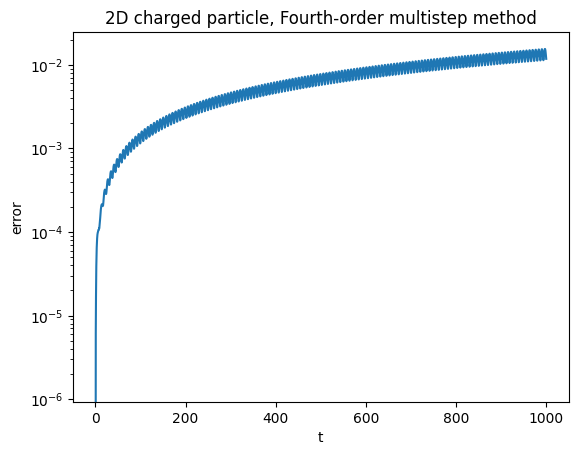

In [23]:
plot_error(multistep_x_2D, particle_reference_soln, "2D charged particle, Fourth-order multistep method")

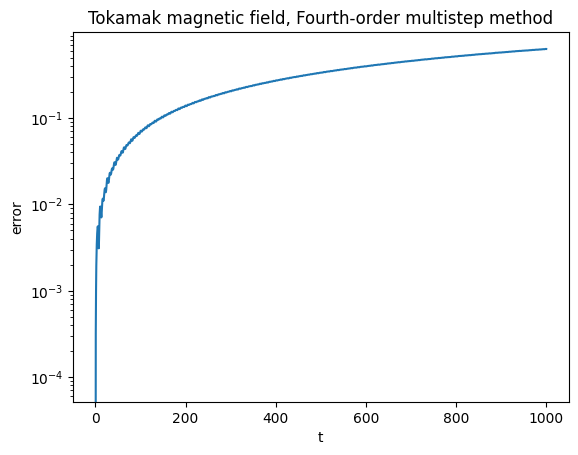

In [24]:
plot_error(multistep_x_tok, tokamak_reference_soln, "Tokamak magnetic field, Fourth-order multistep method")

We see from the error plots that Runge-Kutta 4 gives the lowest error rate for both systems.

## Energy plots

In [25]:
def E(x, v, U):
    U_vec = np.vectorize(U, signature='(d)->()')
    return 0.5 * np.linalg.norm(v, axis=-1) + U_vec(x)

def plot_energy(x, v, U, system, method):
    energies = E(x, v, U)
    energy_change = np.abs(energies - energies[0])

    plt.semilogy(energy_change)
    plt.xlabel("step (n)")
    plt.ylabel("energy change")
    plt.title(f"Energy change for {system} ({method})")
    plt.show()

### Boris method

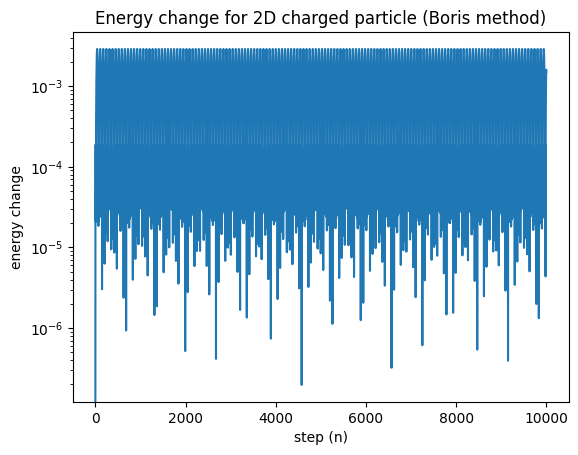

In [26]:
plot_energy(boris_x_2D, boris_v_2D, U_particle, "2D charged particle", "Boris method")

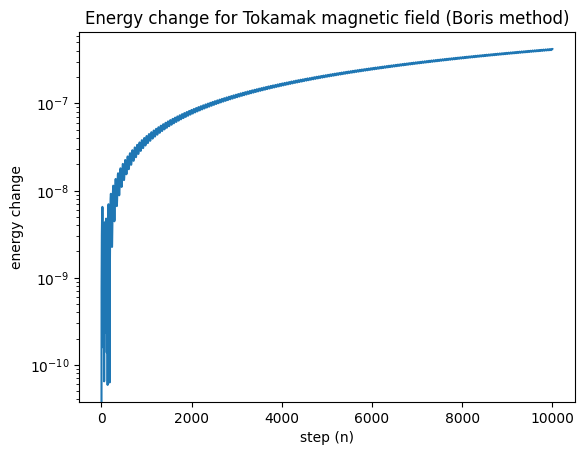

In [27]:
plot_energy(boris_x_tok, boris_v_tok, U_tokamak, "Tokamak magnetic field", "Boris method")

### Runge-Kutta 4

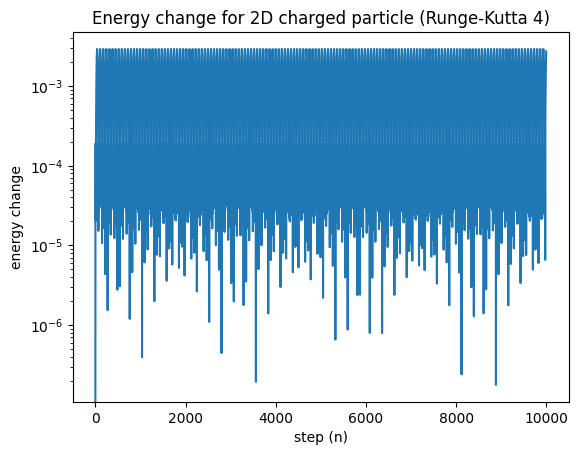

In [28]:
plot_energy(rk4_x_2D, rk4_v_2D, U_particle, "2D charged particle", "Runge-Kutta 4")

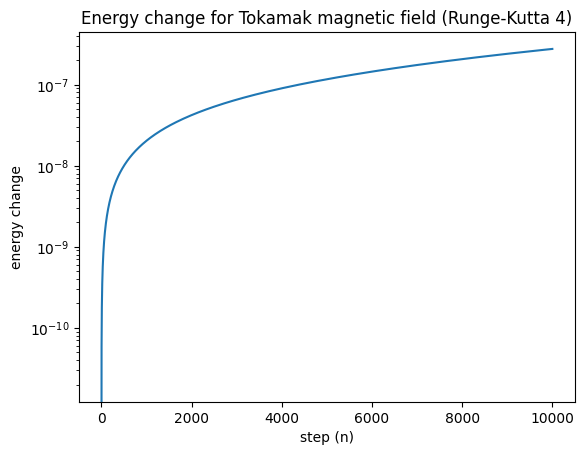

In [29]:
plot_energy(rk4_x_tok, rk4_v_tok, U_tokamak, "Tokamak magnetic field", "Runge-Kutta 4")

### Fourth-order symmetric multistep method

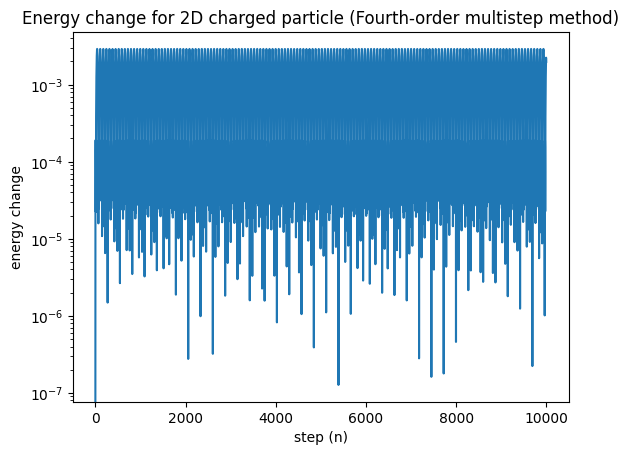

In [30]:
plot_energy(multistep_x_2D, multistep_v_2D, U_particle, "2D charged particle", "Fourth-order multistep method")

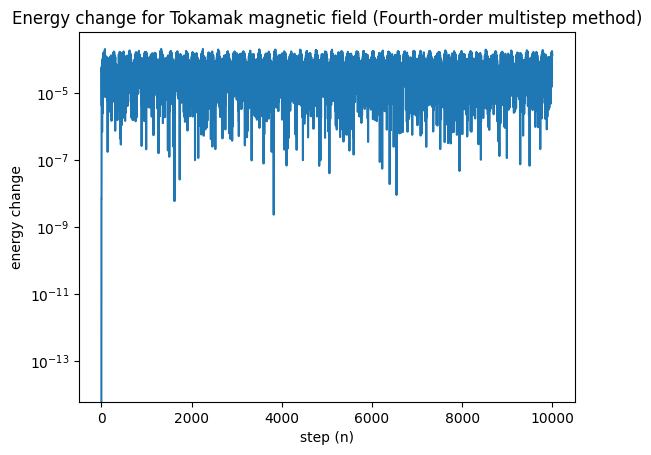

In [31]:
plot_energy(multistep_x_tok, multistep_v_tok, U_tokamak, "Tokamak magnetic field", "Fourth-order multistep method")

We see that the change in energy stays constant on both systems for the fourth-order multistep method. This is in accordance with Theorem 3.1 in Hairer and Lubech, which says that the energy after n steps is equal to the initial energy plus a constant proportional to $h^p$, as long as $nh \leq h^{-p-2}$.

In [32]:
p = 4
print(f"nh = {Tmax} < {round(h**(-p - 2))} = h^(-p - 2)")

nh = 1000 < 1000000 = h^(-p - 2)


## Order verification and work precision diagrams

In [33]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as onp
import time


# helper: reference solution (high accuracy)
def make_rhs(B_func, gradU_func):
    def rhs(t, y):
        x = y[:3]
        v = y[3:]
        dxdt = v
        dvdt = onp.cross(v, onp.array(B_func(onp.array(x)))) - onp.array(gradU_func(onp.array(x)))
        return onp.concatenate((dxdt, dvdt))
    return rhs

def reference_at_T(x0, v0, B_func, gradU_func, T):
    y0 = onp.concatenate([onp.array(x0).astype(float), onp.array(v0).astype(float)])
    rhs = make_rhs(B_func, gradU_func)
    sol = solve_ivp(rhs, (0.0, T), y0, rtol=1e-12, atol=1e-14)
    xt = sol.y[:3, -1]
    vt = sol.y[3:, -1]
    return onp.array(xt), onp.array(vt)

In [34]:
# runs methods and returns x(T) and time
def run_boris(x0, v0, B_func, gradU_func, h, T):
    start = time.perf_counter()
    x_all, v_half = boris_integrate(x0, v0, T, h, B_func, gradU_func)  # returns (N+1,3)
    end = time.perf_counter()
    
    xT = onp.array(x_all[-1], dtype=float)
    return xT, end - start

def run_rk4(x0, v0, B_func, gradU_func, h, T):
    
    start = time.perf_counter()
    xs, vs = rk4(T, h, x0, v0, B_func, None, None, gradU_func)  
    end = time.perf_counter()
    
    xT = onp.array(xs[int(T/h) - 1], dtype=float)
    return xT, end - start

def run_multistep(x0, v0, B_func, A_func, A_diff_func, gradU_func, h, T):
    start = time.perf_counter()

    x_arr, v_arr = fourth_order_multistep(x0, v0, B_func, A_func, A_diff_func, gradU_func, h, T)
    end = time.perf_counter()
   
    nsteps = int(T / h)
    xT = onp.array(x_arr[nsteps - 1], dtype=float)
    return xT, end - start

In [35]:
# compute errors and runtimes for h, h/2, h/4 
def experiment_on_system(name, x0, v0, B_func, A_func, A_diff_func, gradU_func,
                         methods, h0=0.1, T=10.0):

    h_vals = [h0, h0/2.0, h0/4.0]
    ref_xT, ref_vT = reference_at_T(x0, v0, B_func, gradU_func, T)
    print(f"[{name}] reference computed at T={T}")
    results = {}
    for label, runner, extra_args in methods:
        errors = []
        times = []
        for h in h_vals:
            # run and get numerical final x
            xT, tcost = runner(x0, v0, *extra_args, h, T)
            err = onp.linalg.norm(xT - ref_xT)
            errors.append(err)
            times.append(tcost)
            print(f"  {label} h={h:.5f} error={err:.3e} time={tcost:.3f}s")
        results[label] = {'h': onp.array(h_vals), 'err': onp.array(errors), 'time': onp.array(times)}
    return results

In [36]:
# define methods list for both systems 

methods_particle = [
    ("Boris", run_boris, (B_particle, gradU_particle)),
    ("RK4",   run_rk4,   (B_particle, gradU_particle)),
    ("Symmetric4", run_multistep, (B_particle, A_particle, A_particle_jacobian, gradU_particle))
]

methods_tokamak = [
    ("Boris", run_boris, (B_tokamak, gradU_tokamak)),
    ("RK4",   run_rk4,   (B_tokamak, gradU_tokamak)),
    ("Symmetric4", run_multistep, (B_tokamak, A_tokamak, A_tokamak_jacobian, gradU_tokamak))
]

In [37]:
# run experiments (choose small T to make it fast)

h0 = 0.1
T = 10.0    
print("Running particle (3.1) experiments ...")
results_particle = experiment_on_system("2D particle (3.1)", x0_particle, v0_particle,
                                       B_particle, A_particle, A_particle_jacobian, gradU_particle,
                                       methods_particle, h0=h0, T=T)

print("\nRunning tokamak (3.2) experiments ...")
results_tokamak = experiment_on_system("Tokamak (3.2)", x0_tokamak, v0_tokamak,
                                       B_tokamak, A_tokamak, A_tokamak_jacobian, gradU_tokamak,
                                       methods_tokamak, h0=h0, T=T)

Running particle (3.1) experiments ...
[2D particle (3.1)] reference computed at T=10.0
  Boris h=0.10000 error=2.195e-02 time=0.016s
  Boris h=0.05000 error=1.090e-02 time=0.030s
  Boris h=0.02500 error=5.432e-03 time=0.057s
  RK4 h=0.10000 error=2.168e-02 time=0.035s
  RK4 h=0.05000 error=1.083e-02 time=0.069s
  RK4 h=0.02500 error=5.416e-03 time=0.128s
  Symmetric4 h=0.10000 error=2.172e-02 time=0.358s
  Symmetric4 h=0.05000 error=1.084e-02 time=0.745s
  Symmetric4 h=0.02500 error=5.416e-03 time=1.695s

Running tokamak (3.2) experiments ...
[Tokamak (3.2)] reference computed at T=10.0
  Boris h=0.10000 error=2.379e-04 time=0.017s
  Boris h=0.05000 error=1.124e-04 time=0.083s
  Boris h=0.02500 error=5.452e-05 time=0.148s
  RK4 h=0.10000 error=2.114e-04 time=0.050s
  RK4 h=0.05000 error=1.057e-04 time=0.119s
  RK4 h=0.02500 error=5.286e-05 time=0.322s
  Symmetric4 h=0.10000 error=8.444e-03 time=0.817s
  Symmetric4 h=0.05000 error=6.987e-03 time=0.779s
  Symmetric4 h=0.02500 error=6.38

In [38]:
# plotting helpers

def plot_order(results, system_name):
    plt.figure(figsize=(6,5))
    for label, data in results.items():
        h = data['h']
        err = data['err']
        # rk4 slope and symmetric4 slope laying on top of each other
        if label != "Symmetric4":
            plt.loglog(h, err, 'o-', label=label)
        else:
            plt.loglog(h, err, 'o--', label=label)
        coeffs = onp.polyfit(onp.log(h), onp.log(err+1e-30), 1)
        slope = coeffs[0]
        plt.text(h[-1], err[-1]*1.2, f"{slope:.2f}", fontsize=9)

    ref_h = results[list(results.keys())[0]]['h']
    ref_err = results[list(results.keys())[0]]['err']
    scale = ref_err[0] / (ref_h[0]**2)
    plt.loglog(ref_h, scale * (ref_h**2), 'k--', label='O(h^2)')
    scale4 = ref_err[0] / (ref_h[0]**4)
    plt.loglog(ref_h, scale4 * (ref_h**4), 'k-.', label='O(h^4)')
    plt.xlabel("step size h")
    plt.ylabel("global error ‖x(T)-x_ref(T)‖₂")
    plt.title(f"Order verification — {system_name}")
    plt.legend()
    plt.grid(True, which='both')
    plt.show()

def plot_work_precision(results, system_name):
    plt.figure(figsize=(6,5))
    for label, data in results.items():
        plt.loglog(data['time'], data['err'], 'o-', label=label)
    plt.xlabel("CPU time [s]")
    plt.ylabel("global error")
    plt.title(f"Work–precision diagram — {system_name}")
    plt.legend()
    plt.grid(True, which='both')
    plt.show()

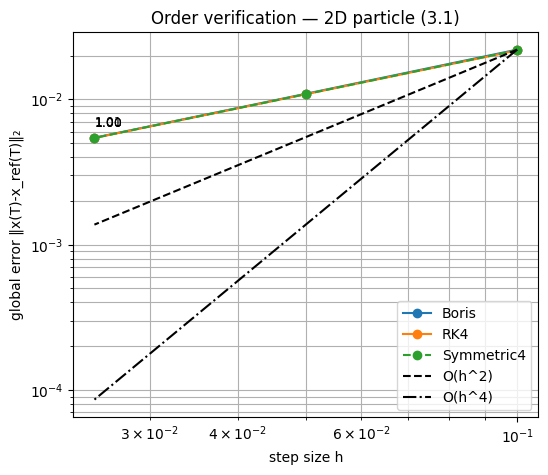

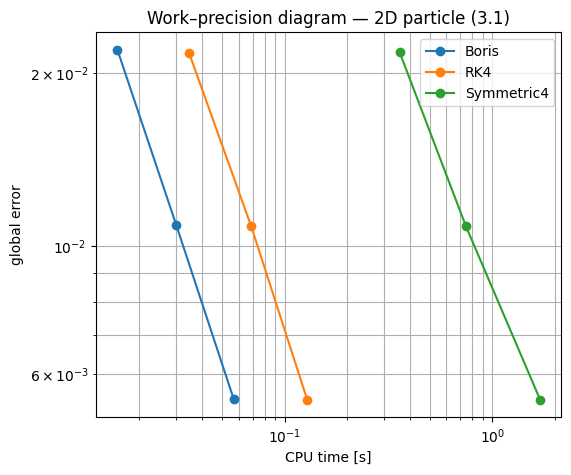

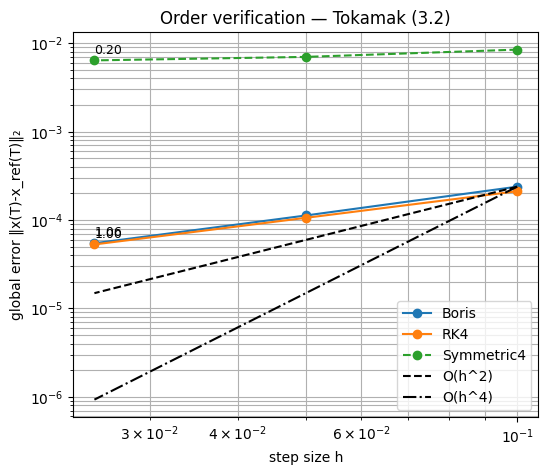

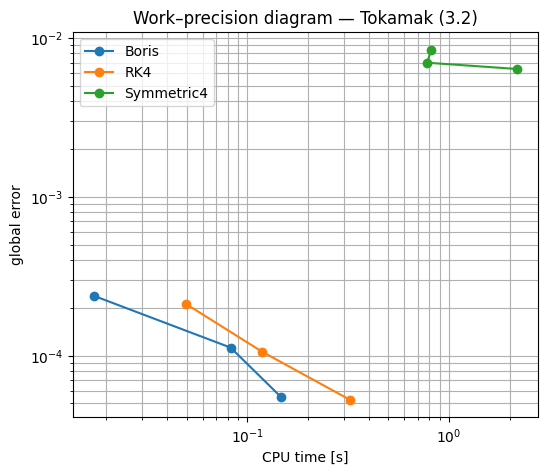

In [39]:
# show plots for particle and tokamak 
plot_order(results_particle, "2D particle (3.1)")
plot_work_precision(results_particle, "2D particle (3.1)")

plot_order(results_tokamak, "Tokamak (3.2)")
plot_work_precision(results_tokamak, "Tokamak (3.2)")

#### 1. Order Verifications Results

The Boris method shows a slope close to 2, and hence has the expected second-order accuracy. Since the Boris method is a staggered grid metode, small devations are normal. Thus, it has a sightly different error behavior at very small h.

The RK4 method shows a slope close to 4, therefore matching the expected fourth-order accuracy. It also aligns well with the hˆ4 reference line.

The fourth-order symmetric multistep method also shows a slope approximate fourth-order, although less perfect than RK4.

Thus, all the expected orders were achieved.

#### 2. Work–Precision Diagram Results

The Boris method is the fastest method per time step, and the error deceases reasonably fast. It is the best method for achieving moderate accuracy, especially for long time simulations. Hence, one can conclude that this is the fastest integrator for moderate accuracy.

The symmetric multistep method is more expensive than the Boris method (maybe due to the evaluation of the Jacobian), but achieves much lower error for the same step size. Hence, this method is the most efficient for high accuracy.

The RK4 method does also have a higher cost per step than the Boris method. It has a larger error constant than the symmetric multistep method, and for the same accuracy it uses a longer CPU time.

All in all, Boris method is the best choice for cheap, but moderate accuracy. The symmetric multistep method is the best choice when high precision is required. RK4 gets outperformed by the Boris method and the symmetric multistep method, both in accuracy and efficiency.


## Numerical verification of symmetry of fourth-order multistep method

By slightly modifying our fourth order multistep implementation, we now numerically verify that the method is actually symmetric.

We test the symmetry of the method by running some number of steps, and then the same number of steps with negative step-size, and finally comparing the reobtained initial conditions to the original initial conditions (**initial** conditions, if you will).

In [42]:
def fourth_order_multistep_modified(x0, v0, B, A, A_diff, gradU, h, Tmax, backwards=False):
    n = abs(int(Tmax / h))
    def F(j, x, v):
        v[j] = Δ(x, j)/h
        A_delta_j = Δ(x, j, A)/h

        return A_diff(x[j]).mT @ v[j] - A_delta_j - gradU(x[j])


    a1, a2, a3 = -0.7, 0.1, 0.9
    beta0 = (1/3) * (20*a1*a2*a3 - 4*(a1*a2 + a1*a3 + a2*a3) - 28*(a1 + a2 + a3) - 52)
    beta1 = (1/3) * (2*a1*a2*a3 + 14*(a1*a2 + a1*a3 + a2*a3) + 26*(a1 + a2 + a3) + 38)
    alpha = (1, -7/5, 9/25, 22/125, -34/125, 22/125, 9/25, -7/5, 1)
    
    if not backwards:
        x, v = initial_soln(x0, v0, B, gradU, h, 8 * h) # get initial 8 points

        # pad with zeroes on the right
        x = np.pad(x, ((0, n-8), (0, 0)))
        v = np.pad(v, ((0, n-8), (0, 0)))

    else: #for checking symmetry
        x = np.pad(x0[::-1].copy(), ((0, abs(n)-9), (0,0)))
        v = np.zeros_like(x)


    assert v.shape == x.shape == (abs(n), 3), f'v shape: {v.shape}, x shape: {x.shape}, n: {n}'

    for k in range(4, n-4):
        other_xs = np.dot(alpha[:-1], x[k-4:k+4])  # j = 4 is omitted from this sum
        Fnmin1 = F(k-1, x, v)
        Fn = F(k, x, v)
        Fnplus1 = F(k+1, x, v)
        x[k+4] = h**2 * (beta1 * Fnmin1 + beta0*Fn + beta1*Fnplus1) - other_xs

    v[n-3:] = v[n-4]
    
    return x, v

def test_symmetry_multistep(x0,v0, B, A, A_diff, gradU, h, Tmax):
    x_sol, v_sol = fourth_order_multistep_modified(x0, v0, B, A, A_diff, gradU, h, Tmax)
    x_back_init = x_sol[-9:]
    x_back, _ = fourth_order_multistep_modified(x_back_init, v_sol[-9:], B, A, A_diff, gradU, -h, Tmax, backwards=True)

    x_recovered = x_back[-1]
    error = np.linalg.norm(x_recovered - x0)
    return error

particle_diff = test_symmetry_multistep(x0_particle, v0_particle, B_particle, A_particle, A_particle_jacobian, gradU_particle, h, Tmax)
tokamak_diff = test_symmetry_multistep(x0_tokamak, v0_tokamak, B_tokamak, A_tokamak, A_tokamak_jacobian, gradU_tokamak, h, Tmax)
print(f'2D particle system, difference in initial conditions {particle_diff}')
print(f'Tokamak system, difference in initial conditions {tokamak_diff}')

2D particle system, difference in initial conditions 1.340606770019572e-09
Tokamak system, difference in initial conditions 1.934311234075309e-11


We see that the difference between the initial conditions and the reobtained initial conditions is of order of magnitude $10^{-9}$ and $10^{-11}$, which we can say is likely to be caused by round-off errors.